# Introduction to atomman: Dislocation class

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook outlines the use of the Dislocation class that can be used to easily generate atomic configurations containing a perfectly straight dislocation.  The class can construct the dislocation system to be either

1. a monopole configuration in which a single dislocation is inserted along one box axis and the other two directions are non-periodic with the expectation that the boundary atoms will be controlled by an elastic solution, or
2. a periodic array of dislocations configuration in which a single dislocation is created in a system that is periodic in the two box directions within the slip plane.

This class relies on the use of the Volterra dislocation models for generating the initial dislocation configurations.  See the [04.2. Volterra dislocation models Jupyter Notebook](04.2._Volterra_dislocation_models.html) for more details on the theory and the Volterra solutions.  

In [1]:
# Standard Python libraries
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today()) 

atomman version = 1.3.4
Notebook executed on 2020-09-17


## 2. Underlying theory

This class is meant to provide a simpler and more convenient means of generating dislocation monopole and periodic array of dislocations atomic configurations.  The dislocation configurations generated by this class contain a single dislocation which is inserted into an otherwise perfect crystalline system by applying displacements corresponding to a dislocation solution.  The boundary conditions are then handled differently based on whether the system is to be a dislocation monopole configuration or a periodic array of dislocations configuration.

### 2.1. Dislocation definition

A type of dislocation can be fully defined relative to a unit cell, ucell, by specifying the Miller slip plane, $n_{(hkl)}$, the Miller Burgers vector, $b_{[uvw]}$, and the Miller line direction, $\xi_{[uvw]}$.  Defining dislocations using Miller planes and vectors rather than Cartesian planes and vectors is more convenient as the definitions hold true for all crystals associated with a given crystal prototype, and this is how dislocations are typically defined by materials scientists.  
The dislocation's character (screw, edge, mixed) is given by the angle between the Burgers vector and the line direction.

Atomic dislocation configurations require a few more parameters to uniquely define how the continuum-based dislocation solutions align with the discrete atomic positions.  The orientation of the dislocation solution with respect to the final atomic configuration is handled by specifying the dislocation solution axes $m$ and $n$ as Cartesian unit vectors.  For simplicity, this method reqiures that $\hat{m}$, $\hat{n}$, and $\hat{\xi} = \hat{m} \times \hat{n}$ are aligned with the three Cartesian axes.  A rigid body shift, $\delta$ is also defined that adjusts the atomic positions such that the mathematical position of the dislocation line and/or slip plane can be properly placed relative to the atoms.

The slip plane normal relative to the unit cell, $n_{ucell}$, is identified by converting $n_{(hkl)}$ into Cartesian units. Using $n_{ucell}$, three Miller crystal vectors are identified that determine how to rotate the unit cell

- The Miller vector $\xi_{[uvw]}$.
- The Miller vector with $|u|,|v|,|w|$ values less than some maximum in the slip plane that is closest to perpendicular to $\xi_{[uvw]}$.
- The Miller vector with $|u|,|v|,|w|$ values less than some maximum that is closest to being parallel to $n_{ucell}$.

The values of $\hat{m}$, $\hat{n}$ and $\hat{\xi}$ determine how these three Miller vectors are associated with the box rotation vectors, $a_{[uvw]}$, $b_{[uvw]}$, and $c_{[uvw]}$.

- $\hat{\xi}$ determines which axis, $x, y, z$, and which respective box vector, $a_{rcell}, b_{rcell}, c_{rcell}$, that $\xi_{[uvw]}$ is associated with.
- $\hat{n}$ determines which axis, $x, y, z$, that the slip plane is normal to, and which respective box vector, $a_{rcell}, b_{rcell}, c_{rcell}$ that the out-of-plane Miller vector is associated with.  Note that the out-of-plane vector need not be parallel to the slip plane normal, rather it simply be the only box vector with a component in the $\hat{n}$ direction.  

A rotated cell, rcell, is then created using ucell and the rotation vectors.  This rotated cell serves as the seed for constructing the larger atomic configurations in which the dislocation is inserted.  As rcell is constructed, the Cartesian transformation matrix, $T$, associated with transforming from the ucell orientation to the rcell orientation is also identified. $T$ is then used to convert $b_{[uvw]}$ to the Cartesian $b$ vector.

The rigid body shift, $\delta$, is defined relative to rcell as it is applied to the atoms in the rotated state.  For dislocations defined relative to crystal prototypes, $\delta$ can be expressed in reduced coordinates relative to ucell.  Alternatively, rcell itself can be used to identify shifts normal to the slip plane that place the mathematical slip plane halfway between all atomic planes in rcell.  This allows for dislocations to be easily generated either from pre-defined parameters or based on optimum shift reccomendations.   


### 2.2. Dislocation solutions

Dislocation configurations are created by building perfect crystal base systems by replicating rcell along the box vectors, then displacing the atomic positions according to a dislocation solution.  For the dislocation monopole configuration, the elastic solution for a straight Volterra dislocation is used.  More information on the Volterra dislocation solutions can be found in the [04.2. Volterra dislocation models Notebook](04.2._Volterra_dislocation_models.html).

For the periodic array of dislocations configuration, either a linear displacement solution or a combination of linear displacements and a straight Volterra solution is used.  The linear displacement solution applies a linear gradient of displacements to atoms in the system based on their coordinates $m$ and $n$ along the corresponding dislocation solution axes 

$$\vec{d}_{lin}(m, n) = \frac{\vec{b}}{2} - \text{sign}(n)\left[ \frac{m\vec{b}}{2l} + \frac{\vec{b}}{4}\right],$$

where $l$ is the full periodic length of the system in the $\hat{m}$ direction. By applying opposite displacements above and below the slip plane, the atomic disregistry linearly varies from 0 to $b$ across the system. While this does not give a good approximation of a real dislocation, it does have a couple of benefits besides its simplicity.  First, the solution is independent of the dislocation's position along the slip plane.  This makes it a good choice of displacements for the non-periodic surfaces if the atoms are held rigidly as the interaction between the dislocation and the boundaries will remain constant as the dislocation moves.  Also, since $\vec{d}_{lin}$ depends on $\text{sign}(n)$ rather than $n$ the solution on each side of the slip plane only depends on $m$.   

### 2.3. Boundary conditions

#### 2.3.1. Dislocation monopoles

A dislocation monopole is an atomic configuration that contains a single straight dislocation.  

- The box direction parallel to the dislocation line is made periodic.  The other two box directions are non-periodic.
- A boundary region is defined that encompases the atoms near the non-periodic boundaries.  This region is identified by changing the atype values of the atoms in those geometric regions.

The Dislocation class constructs the atomic configurations but leaves it up to users to define how to relax the system.  Typically, monopole systems are relaxed using MD steps and/or energy/force minimizations that operate on the atoms not in the boundary regions, while atoms in the boundaries are held fixed.  From there, two types of relaxations are described as having "rigid" or "flexible" boundaries. 

A rigid boundary relaxation is one in which the boundary atoms are never adjusted after the initial system construction.  As the atoms are held at a dislocation solution, the initial positions tend to be a decent guess for dislocations with compact cores.  However, a misfit force will arise at the interface between the boundary and non-boundary atoms that can influence the dislocation structure, energies and behavior.  The influence of the misfit force can be minimized by constructing large atomic configurations and keeping investigations to dislocations with compact cores that remain positioned near the center of the systems.

A flexible boundary relaxation is one in which the boundary atoms are subjected to an alternative relaxation method, such as the lattice Greens function.  This alternative relaxation method allows for the misfit forces at the interface betweeen the boundary and non-boundary atoms to be reduced while preventing the atoms at the non-periodic box boundaries from forming free surfaces.  This method is preferred for expensive atomistic methods like DFT as it gives good structure predictions as long as the dislocation core itself remains in the non-boundary region.


#### 2.3.2. Periodic array of dislocations

A periodic array of dislocations atomic configuration is one in which the system itself only contains one dislocation, but the system's box boundary conditions are such that it represents an infinite array of equally spaced dislocations.

- The two box directions in the slip plane are made periodic while the out-of-plane box direction is non-periodic.
- The box dimensions are modified to ensure that the atoms remain compatible and coherent across the two periodic box directions.
- For dislocations with edge components, the atomic compatibility requires that a half-plane of atoms either be inserted or deleted.  This is handled here by shrinking the box dimensions and identifying the half-plane of atoms to delete as those that have nearly identical positions with other atoms in the shrunken system.
- A boundary region is identified at the non-periodic surface.  The atoms in the boundary region are identified by changing their atype values, and are given coordinates that correspond to the global linear displacements rather than the local dislocation displacements.

The choice of displacing the atoms in the boundary region by a linear gradient of displacements rather than the dislocation solution displacements is done as the linear gradient is independent of the dislocation's position.  Yes, there will be misfit forces at the interface between the boundary and non-boundary regions, but those forces will be (mostly) independent of the dislocation's position in the system.  The slip behavior of dislocations can therefore be studied by applying shear strains/stresses to the system by adding displacements/forces to the boundary atoms. Some examples:

- Quasistatic calculations in which energy/force relaxations are used after incremental displacements of the boundaries. This can be used to estimate the Peierls barrier, with good estimates requiring very small force relaxation tolerances and very small displacements at each iteration.

- Strain-controlled simulations in which a constant displacement rate is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary atoms only move in the displacement direction, or free-surface boundaries, in which motion in the displacement direction is fixed but MD motions in perpendicular directions are allowed.

- Stress-controlled simulations in which a constant force is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary is treated as a rigid block that the force acts on, or free-surface boundaries, in which the boundary atoms are subjected to MD steps but each has an extra constant force applied to it. 

## 3. Dislocation initialization

The Dislocation class is initialized by giving it parameters associated with the crystal information and the dislocation definition.

Crystal parameters

- __ucell__ (*atomman.System*) The unit cell to use as the seed for generating the dislocation monopole system.
- __C__ (*atomman.ElasticConstants*) The elastic constants associated with the bulk crystal structure for ucell.

Dislocation parameters

- __burgers__ (*array-like object*) The dislocation's Burgers vector given as a Miller or Miller-Bravais vector relative to ucell.
- __ξ_uvw__ (*array-like object*) The dislocation's line direction given as a Miller or Miller-Bravais vector relative to ucell.
- __slip_hkl__ (*array-like object*) The dislocation's slip plane given as a Miller or Miller-Bravais plane relative to ucell.
- __m__ (*array-like object, optional*) The m unit vector for the dislocation solution.  m, n, and ξ (dislocation line) should be right-hand orthogonal.  Default value is \[0,1,0\] (y-axis).
- __n__ (*array-like object, optional*) The n unit vector for the dislocation solution.  m, n, and ξ (dislocation line) should be right-hand orthogonal.  Default value is \[0,0,1\] (z-axis). n is normal to the dislocation slip plane.
- __tol__ (*float*) A cutoff tolerance used with obtaining the dislocation solution. Only needs to be changed if there are issues with obtaining a solution.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.


Define the crystal information: ucell and C

In [2]:
ucell = am.load('prototype', 'A1--Cu--fcc', a=4.05, remote=False)
print(ucell)
print()

C = am.ElasticConstants(C11 = uc.set_in_units(105, 'GPa'),
                        C12 = uc.set_in_units(70, 'GPa'), 
                        C44 = uc.set_in_units(45, 'GPa'))
print('Cij (GPa) =')
print(uc.get_in_units(C.Cij, 'GPa'))

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000

Cij (GPa) =
[[105.  70.  70.   0.   0.   0.]
 [ 70. 105.  70.   0.   0.   0.]
 [ 70.  70. 105.   0.   0.   0.]
 [  0.   0.   0.  45.   0.   0.]
 [  0.   0.   0.   0.  45.   0.]
 [  0.   0.   0.   0.   0.  45.]]


Define the dislocation 

In [3]:
# FCC a/2<101>{111} dislocation
burgers = np.array([0.5, 0.0, -0.5])
slip_hkl = np.array([1,1,1])

# Line direction determines dislocation character
#ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw

Initialize the Dislocation object using the above parameters

In [4]:
disl = am.defect.Dislocation(ucell, C, burgers, ξ_uvw, slip_hkl)

or, load dislocation parameters from a file

In [5]:
#model = 'C:/Users/lmh1/Documents/library/dislocation/A2--W--bcc--a-2-111--0-screw--{110}.json'
#disl = am.defect.Dislocation.fromref(ucell, C, model)

The Dislocation object has a number of attributes that describe the basic setup.

In [6]:
print('Transformation matrix =')
print(disl.transform)
print()

print('Rotation uvws =')
print(disl.uvws)
print()

print('Unit cell =')
print(disl.ucell)
print()

print('Rotated cell =')
print(disl.rcell)
print()

Transformation matrix =
[[ 0.40824829  0.40824829 -0.81649658]
 [-0.70710678  0.70710678  0.        ]
 [ 0.57735027  0.57735027  0.57735027]]

Rotation uvws =
[[ 1.  1. -2.]
 [-1.  1.  0.]
 [ 1.  1.  1.]]

Unit cell =
avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000

Rotated cell =
avect =  [ 9.920,  0.000,  0.000]
bvect =  [ 0.000,  5.728,  0.000]
cvect =  [ 0.000,  0.000,  7.015]
origin = [ 0.000,  0.000,  0.000]
natoms = 24
natypes = 1
symbols = (None,)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  

A Volterra dislocation solution is also obtained, which is accessible as the dislsol attribute

In [7]:
print(f'character angle = {disl.dislsol.characterangle()} degrees')
print(f'K_coeff = {uc.get_in_units(disl.dislsol.K_coeff, "GPa"):.3f} GPa')
print('burgers =', uc.get_in_units(disl.dislsol.burgers, "angstrom"), 'angstrom')

character angle = 30.000000000000004 degrees
K_coeff = 33.399 GPa
burgers = [ 2.48010836 -1.43189123  0.        ] angstrom


The shift values should be selected such that the dislocation falls between atomic positions. For planar dislocations, the slip plane should be placed roughly halfway between atomic planes.  The class automatically identifies all such shifts relative to rcell and stores them as the attribute shifts.

The initialization parameters allow for shifts to be defined in one of three ways:

1. Giving shiftindex indicates which of the identified shifts relative to rcell to use.  If neither shift or shiftindex is specified, then shiftindex=0 is used.
2. Giving shift with shiftscale=False allows for an absolute Cartesian shift to be specified.
3. Giving shift with shiftscale=True allows for a shift relative to rcell's box vectors to be specified.

For non-planar screw dislocations, the dislocation core should be placed in the proper location where the involved slip planes intercept. This can be handled by specifying shifts using options 2 or 3.

Note that the shift can be changed when calling the monopole and periodicarray methods.

In [8]:
print('Identified shifts =')
print(disl.shifts)
print()

print('The shift currently set to be used =', disl.shift)

Identified shifts =
[[0.         0.         1.1691343 ]
 [0.         0.         3.50740289]
 [0.         0.         5.84567148]]

The shift currently set to be used = [0.        0.        1.1691343]


## 4. Dislocation Monopole Configuration


System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given will use the shift set during class initialization.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used then will use the shift set during class initialization.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Boundary parameters

- __boundaryshape__ (*str, optional*) Indicates the shape of the boundary region to use.  Options are 'cylinder' (default) and 'box'.  For 'cylinder', the non-boundary region is defined by a cylinder with axis along the dislocation line and a radius that ensures the boundary is at least boundarywidth thick.  For 'box', the boundary region will be exactly boundarywidth thick all around.      
- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 4.1. Small atomic system example, easy to see atomic positions

In [9]:
base_system, disl_system = disl.monopole(bmin=30, cmin=30,
                                         boundarywidth=1, boundaryscale=True,
                                         return_base_system=True)

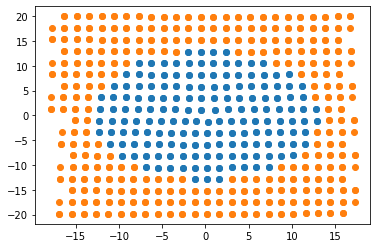

In [10]:
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1], disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')

### 4.2. Large atomic system example, more useful for simulations

In [11]:
base_system, disl_system = disl.monopole(bmin=300, cmin=300,
                                         boundarywidth=1, boundaryscale=True,
                                         return_base_system=True)

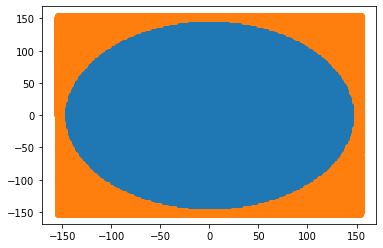

In [12]:
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1], disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')

## 5. Periodic Array of Dislocations Configuration

System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Boundary parameters

- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed and will be displaced by linear displacements.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Method options

- __linear__ (*bool, optional*) If True, then only linear displacements will be used and not the dislocation solution.  Using only linear displacements is useful for screw dislocations and dislocations with large stacking fault distances.  If False (default) then the dislocation solution will be used for the middle displacements and linear displacements only in the boundary region.
- __cutoff__ (*float, optional*) Cutoff distance to use for identifying duplicate atoms to remove. For dislocations with an edge component, applying the displacements creates an extra half-plane of atoms that will have (nearly) identical positions with other atoms after altering the boundary conditions.  Default value is 0.5 Angstrom.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 5.1. Small atomic system example, easy to see atomic positions

In [13]:
base_system, disl_system = disl.periodicarray(bmin=30, cmin=30,
                                              boundarywidth=3, boundaryscale=True,
                                              return_base_system=True)

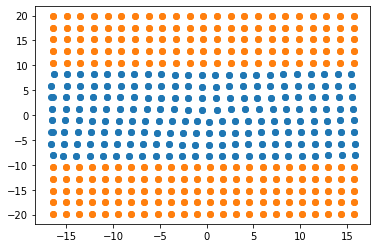

In [14]:
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1], disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')

### 5.2. Large atomic system example, more useful for simulations

In [15]:
base_system, disl_system = disl.periodicarray(bmin=300, cmin=300,
                                              boundarywidth=3, boundaryscale=True,
                                              return_base_system=True)

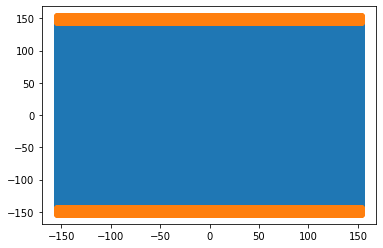

In [16]:
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1], disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')